# Quickstart

`geoplot` is a geospatial data visualization library designed for data scientists and geospatial analysts that just want to get things done. In this tutorial we will learn the basics of `geoplot` and see how it is used.

You can run this tutorial code yourself interactively using [Binder](https://mybinder.org/v2/gh/ResidentMario/geoplot/master?filepath=notebooks/tutorials/Quickstart.ipynb).

In [1]:
# Configure matplotlib.
%matplotlib inline

# Unclutter the display.
import pandas as pd; pd.set_option('max_columns', 6)

## Getting geospatial data

The starting point for geospatial analysis is geospatial data. The standard way of dealing with such data in Python using `geopandas`&mdash;a geospatial data parsing library over the well-known `pandas` library.

In [2]:
import geopandas as gpd

`geopandas` represents data using a `GeoDataFrame`, which is just a `pandas` `DataFrame` with a special `geometry` column containing a geometric object describing the physical nature of the record in question: a `POINT` in space, a `POLYGON` in the shape of New York, and so on.

In [3]:
import geoplot as gplt
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
usa_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
0,53,40888.0,1611.0,ND,POINT (-101.2962732 48.23250950000011)
1,101,52838.0,830.0,ND,POINT (-97.03285469999997 47.92525680000006)
2,153,15427.0,1407.0,ND,POINT (-98.70843569999994 46.91054380000003)
3,177,105549.0,902.0,ND,POINT (-96.78980339999998 46.87718630000012)
4,192,17787.0,2411.0,ND,POINT (-102.7896241999999 46.87917560000005)


<div style="margin-top:2em">
All functions in `geoplot` take a `GeoDataFrame` as input.

> Note that `shapely`, the library `geopandas` uses to store its geometries, uses "modern" longitude-latitude `(x, y)` coordinate order. This differs from the "historical" latitude-longitude `(y, x)` coordinate order. Datasets "in the wild" may be in either format, so after reading in some data make sure to verify that your coordinates are in the right order!

To learn more about manipulating geospatial data, check out the section of the tutorial on [Working with Geospatial Data](https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html).
</div>

## Plotting points and polygons

In [4]:
import geoplot as gplt

If your data consists of a bunch of points, you can display those points using `pointplot`.

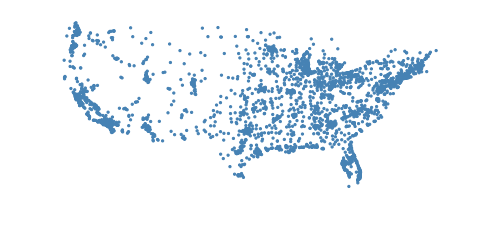

In [5]:
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
gplt.pointplot(continental_usa_cities)

If you have polygonal data instead, you can plot that using a `geoplot` `polyplot`.

In [6]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

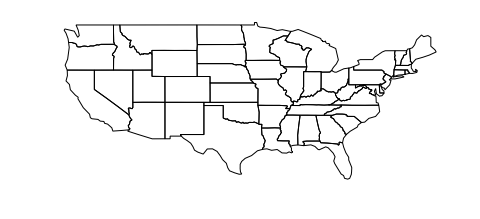

In [7]:
gplt.polyplot(contiguous_usa)

We can combine the these two plots using overplotting. **Overplotting** is the act of stacking several different plots on top of one another, useful for providing additional context for our plots:

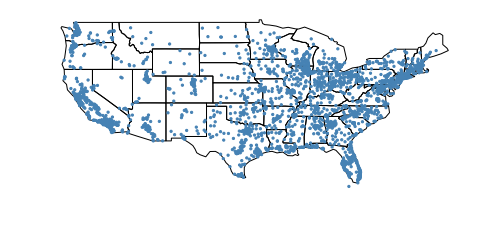

In [8]:
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(continental_usa_cities, ax=ax)

You might notice that this map of the United States looks very strange. The Earth, being a sphere, is impossible to potray in two dimensionals. Hence, whenever we take data off the sphere and place it onto a map, we are using some kind of **projection**, or method of flattening the sphere. Plotting data without a projection, or "carte blanche", creates distortion in your map. We can "fix" the distortion by picking a better projection.

The Albers equal area projection is one most common in the United States. Here's how you use it with `geoplot`:

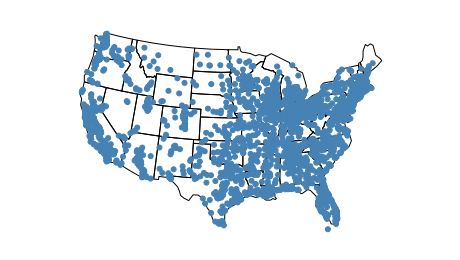

In [9]:
import geoplot.crs as gcrs

ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())
gplt.pointplot(continental_usa_cities, ax=ax)

This looks much better than our first plot! In fact, this is the version of the United States that you'll probably most often see in maps.

To learn more about projections check out the section of the tutorial on [Working with Projections](https://residentmario.github.io/geoplot/user_guide/Working_with_Projections.html).

What if you want to create a **webmap** instead? This is also easy to do.

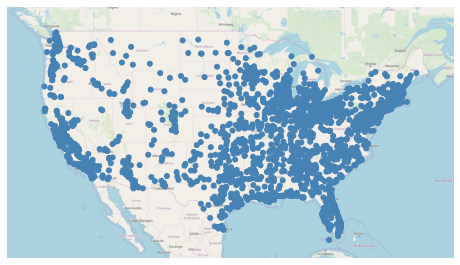

In [15]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax)

`geoplot` can even be used with `mplleaflet` to create animated scrolly-panny webmaps. [Click here](https://residentmario.github.io/geoplot/gallery/plot_boston_airbnb_kde.html) for a demo.

## Adding visual parameters

This map tells us that there are more cities on either coast than there are in and around the Rocky Mountains, but it doesn't tell us anything about the cities themselves. We can make an informative plot by adding more **visual parameters** to our plot.

We'll start with `hue`.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


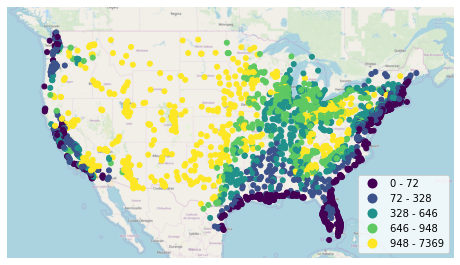

In [20]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax, hue='ELEV_IN_FT', legend=True)

This map tells a clear story: that cities in the central United States have a higher `ELEV_IN_FT` then most other cities in the United States, especially those on the coast. Toggling the legend on helps make this result more interpretable.

Which colors get assigned to which category are controlled by a [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) (or `cmap`). There are over fifty visually distinct colormaps in `matplotlib`; it's also possible to create your own on the fly. This plot uses the default `matplotlib` `cmap`, `viridis`, but we can pick a different one that perhaps better suites our data if we so choose:

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


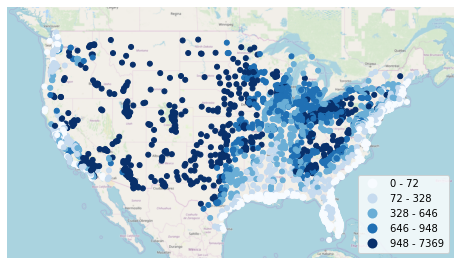

In [21]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax, hue='ELEV_IN_FT', cmap='Blues', legend=True)

Next, let's try adding still another visual variable to our plot: `scale`. We'll also specify two other new parameters: `limits`, which controls the maximum and minimum sizes of the scaled-out points; and `legend_var`, which specifies which visual variable (`scale` or `hue`) will appear in the legend.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


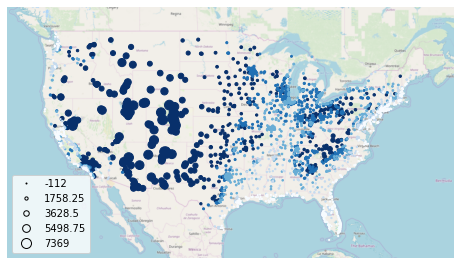

In [23]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(
    continental_usa_cities, ax=ax, hue='ELEV_IN_FT', cmap='Blues',
    scale='ELEV_IN_FT', limits=(1, 10),    
    legend=True, legend_var='scale'
)

This new plot shows more clearly than the previous one the difference in height between cities in the Rocky Mountain states like Colorado, Utah, and Wyoming, and those elsewhere in the United States.

## Making the plot pretty

Ugly maps distract the reader from the story you want to tell. Once you've got the basic outline ready, it's handy to be able to tweak your plot a bit to "prettify" it.

`geoplot` comes equipped with a variety of visual parameters (many of them from `matplotlib`) that can be used to adjust the look and feel of the plot.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cities in the Continental United States by Elevation')

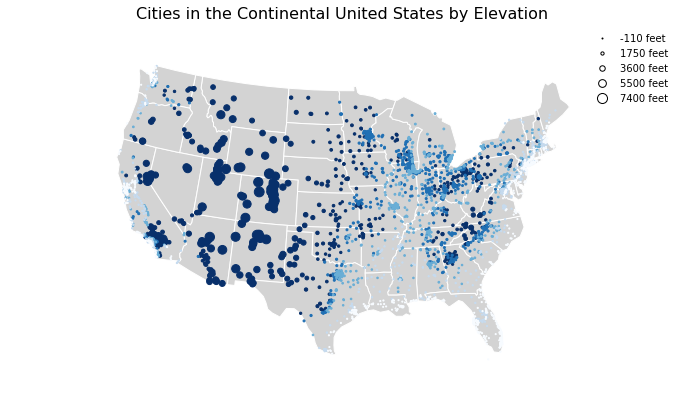

In [24]:
ax = gplt.polyplot(
    contiguous_usa, projection=gcrs.AlbersEqualArea(),
    edgecolor='white', facecolor='lightgray',
    figsize=(12, 8)
)
gplt.pointplot(
    continental_usa_cities, ax=ax, hue='ELEV_IN_FT', cmap='Blues',
    scale='ELEV_IN_FT', limits=(1, 10),    
    legend=True, legend_var='scale',
    legend_kwargs={'frameon': False},
    legend_values=[-110, 1750, 3600, 5500, 7400],
    legend_labels=['-110 feet', '1750 feet', '3600 feet', '5500 feet', '7400 feet']   
)
ax.set_title('Cities in the Continental United States by Elevation', fontsize=16)

## Some other plot types

So far we've worked with `pointplot` and `polyplot`. `geoplot` has a variety of other plot types available as well. We'll take a brief look at just two of them; the full list is covered in detail in the [Plot Reference](https://residentmario.github.io/geoplot/plot_references/plot_reference.html).

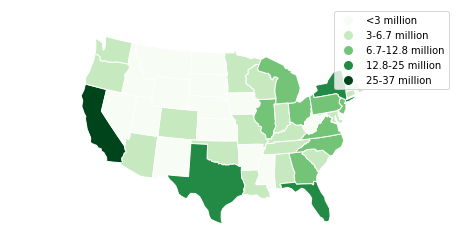

In [25]:
gplt.choropleth(
    contiguous_usa, hue='population', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=1,
    cmap='Greens', legend=True,
    scheme='fisher_jenks',
    legend_labels=[
        '<3 million', '3-6.7 million', '6.7-12.8 million',
        '12.8-25 million', '25-37 million'
    ]
)

This `choropleth` of population by state shows how much larger certain coastal states are than their peers in the central United States. A `choropleth` is the standard-bearer in cartography for showing information about areas because it's easy to make and interpret.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


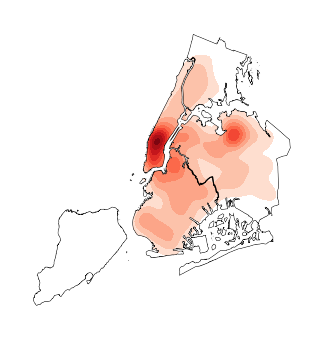

In [26]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
collisions = gpd.read_file(gplt.datasets.get_path('nyc_collision_factors'))

ax = gplt.kdeplot(collisions, cmap='Reds', shade=True, clip=boroughs, projection=gcrs.AlbersEqualArea())
gplt.polyplot(boroughs, zorder=1, ax=ax)

A `kdeplot` smoothes point data out into a heatmap. This makes it easy to spot regional trends in your input data. The `clip` parameter can be used to clip the resulting plot to the surrounding geometry&mdash;in this case, the outline of New York City.

## Next steps

You should now know enough `geoplot` to try it out in your own projects!

To install `geoplot`, run `conda install geoplot`. To see more examples using `geoplot`, check out the [Gallery](https://residentmario.github.io/geoplot/gallery/index.html).